In [3]:
# ORIGINALLY:
# Get the p0 as a function of density!!!
#
# Set velocity to zero (Does this break it?)
#
# NOW:
# Density is a separate parameter. So I'm just going to slice the
# v0 vs p0 parameter space thinner and run more replicates


import sys
import os
import numpy as np
import pandas as pd
import time

# from tqdm import tqdm
# import numba
# import datetime

# vor_path = "/home/ubuntu/git/active_vertex"
vor_path = 'C:\\Users\\Pranav\\git\\active_vertex'
# vor_path = "/home/pbhamidi/git/active_vertex"

sys.path.append(vor_path)

import voronoi_model.voronoi_model_periodic as avm

In [4]:
########################

# Inputs
# to_dir = "/home/pbhamidi/data/2020-09-22_avm_phase_sims_dense4/"
to_dir = "C:\\Users\\Pranav\\git\\evomorph\\scratch"

########################

In [10]:
p_space = np.linspace(3.2, 4.0, 17)
v_space = np.array([5e-4, 1e-3, *np.linspace(2e-3, 3e-2, 15)])
replicates = np.arange(5, dtype=int)

param_space = np.meshgrid(
    p_space,
    v_space,
    replicates
)
param_space = np.array(param_space).T.reshape(-1, 3)

param_space = param_space[:4]

In [11]:
param_space

array([[3.2e+00, 5.0e-04, 0.0e+00],
       [3.2e+00, 1.0e-03, 0.0e+00],
       [3.2e+00, 2.0e-03, 0.0e+00],
       [3.2e+00, 4.0e-03, 0.0e+00]])

In [12]:
########################

f = 200
t0 = 0
tmax = 2

dt = 0.025
n_t = int((tmax - t0) * f / dt) + 1  # calculates the n_t to get the desired dt

# a = 0.4
k = 2
J = 0.
       

In [13]:
common_metadata = dict(f=f, t0=t0, tmax=tmax, dt=dt, n_t=n_t, k=k, J=J)

if not os.path.exists(to_dir):
    os.mkdir(to_dir)

cores = 4
# gen = pcounter((param_space.shape[0] // cores) + 1)

# def count():
#     return next(gen)

In [22]:
def simulate(params, progress_bar=False, print_updates=False):

    p, v, rep = params
    rep = int(rep)
    prefix = f"p0{p:.2f}_v0{v:.2e}_rep{rep}"

    vor2 = avm.Tissue()
    vor2.make_init2(L=14, n_c=235)

    vor2.set_GRN_t_span(t0, tmax, n_t, scaling_factor=f);
    vor2.v0 = v
#    vor2.n_warmup_steps = int(150 / dt)
    vor2.n_warmup_steps = 1

    W = J * np.array([[1, 0], [0, 1]])
    vor2.set_interaction(W=W, pE=0)
    vor2.A0 = vor2.L**2 / vor2.n_c
    vor2.P0 = p * np.sqrt(vor2.A0)

    vor2.Dr = 0.01
    vor2.kappa_A = 0.2
    vor2.kappa_P = 0.1
    vor2.a = vor2.A0 / 2
    vor2.k = k

    start_time = time.time()

    vor2.simulate(progress_bar=progress_bar, print_updates=print_updates);

#     end_time = time.time()
    secs_elapsed = int(end_time) - int(start_time)
#     mins_elapsed = secs_elapsed / 60
#     it_per_sec = vor2.n_t / secs_elapsed

    fname = os.path.abspath(os.path.join(to_dir, prefix))
#     np.save(fname, vor2.x_save, allow_pickle=False)

#     print(f"Thread {count()*100:.2f}% complete")
    return prefix, mins_elapsed, it_per_sec
#     return prefix, [vor_to_D_eff(vor2, n) for n in (7, 19, 37)]

In [23]:
np.sqrt(235 / 120 * 100)

13.99404635312222

In [27]:
# from multiprocessing import Pool
# if __name__ == '__main__':
#     with Pool(cores) as p:
#         results = list(p.imap_unordered(simulate, param_space))

results = []
for params in param_space[:1]:
    results.append(simulate(params,progress_bar=True, print_updates=True))

Warming up SPV (1 steps)


 19%|█▉        | 3068/16000 [00:56<03:57, 54.36it/s]


KeyboardInterrupt: 

In [ ]:
metadata = pd.DataFrame(dict(
    p0=param_space[:, 0],
    v0 = param_space[:, 1],
    rep = param_space[:, 2]
))
for k, v in common_metadata.items():
    metadata[k] = v

coords_fname = []
for _, row in enumerate(metadata[["p0", "v0", "rep"]].values):
    p, v, rep = row
    coords_fname.append(f"p0{p:.2f}_v0{v:.2e}_rep{int(rep)}")
metadata["coords_fname"] = coords_fname

time_df = pd.DataFrame(dict(
    coords_fname=[res[0] for res in results],
    mins_elapsed=[res[1] for res in results],
    it_per_sec=[res[2] for res in results],
))

metadata.to_csv(os.path.join(to_dir, "metadata.csv"))

metadata = metadata.merge(time_df)
metadata.to_csv(os.path.join(to_dir, "metadata_time.csv"))

# print("COMPLETE!")

In [31]:
print("""181 cells 
    compute time per run in min   : {0:.2f}
    total compute time in CPU-hrs : {1:.2f}
--------""".format(
    16000 / 90 / 60,
    16000 / 90 / 60 * 1445 / 60,
))
print("""235 cells
    compute time per run in min   : {0:.2f}
    total compute time in CPU-hrs : {1:.2f}
--------""".format(
    16000 / 60 / 60,
    16000 / 60 / 60 * 1445 / 60,
))
print("""400 cells
    compute time per run in min   : {0:.2f}
    total compute time in CPU-hrs : {1:.2f}
--------""".format(
    16000 / 11 / 60,
    16000 / 11 / 60 * 1445 / 60,
))

181 cells 
    compute time per run in min   : 2.96
    total compute time in CPU-hrs : 71.36
--------
235 cells
    compute time per run in min   : 4.44
    total compute time in CPU-hrs : 107.04
--------
400 cells
    compute time per run in min   : 24.24
    total compute time in CPU-hrs : 583.84
--------


In [1]:
import os
from glob import glob
import tqdm

import numpy as np
import skimage.io as io

import h5py
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

ModuleNotFoundError: No module named 'cv2'

In [16]:
data_dir = "E:/transceiver_project/20200715_time_lapse_propagation/time_lapse_20x/"

In [17]:
vids = [os.path.split(f)[-1] for f in glob(data_dir + "*_*")]

In [18]:
# Read test images
vid = "0test"
ims_f = glob(os.path.join(data_dir, vid, "*/*CH4.tif"))
arr = io.ImageCollection(ims_f)[::2].concatenate()

In [19]:
# Create a new HDF5 file using default properties
file = h5py.File(os.path.join(data_dir, 'dset_test.h5'),'w')

In [20]:
dset = file.create_dataset(vid+"_BF", data=arr)
file.close()

<hr>

In [21]:
# Open an existing file using default properties.
file = h5py.File(os.path.join(data_dir, 'dset_test.h5'),'r+')
keys = list(file.keys())
keys

['0test_BF']

In [23]:
# Open dataset under the root group.
key = '0test_BF'
arr = file[key]

In [24]:
arr_bgs = np.empty_like(arr)
for i, im in enumerate(arr):
    bg = cv2.medianBlur(im, 251, 0)
    bg = bg - bg.min()
    bgs = cv2.subtract(im, bg)
    bgs = cv2.normalize(bgs, bgs, 0, 255, cv2.NORM_MINMAX)
    arr_bgs[i] = bgs

In [25]:
dset = file.create_dataset(key+"_bgs", data=arr_bgs)
file.close()

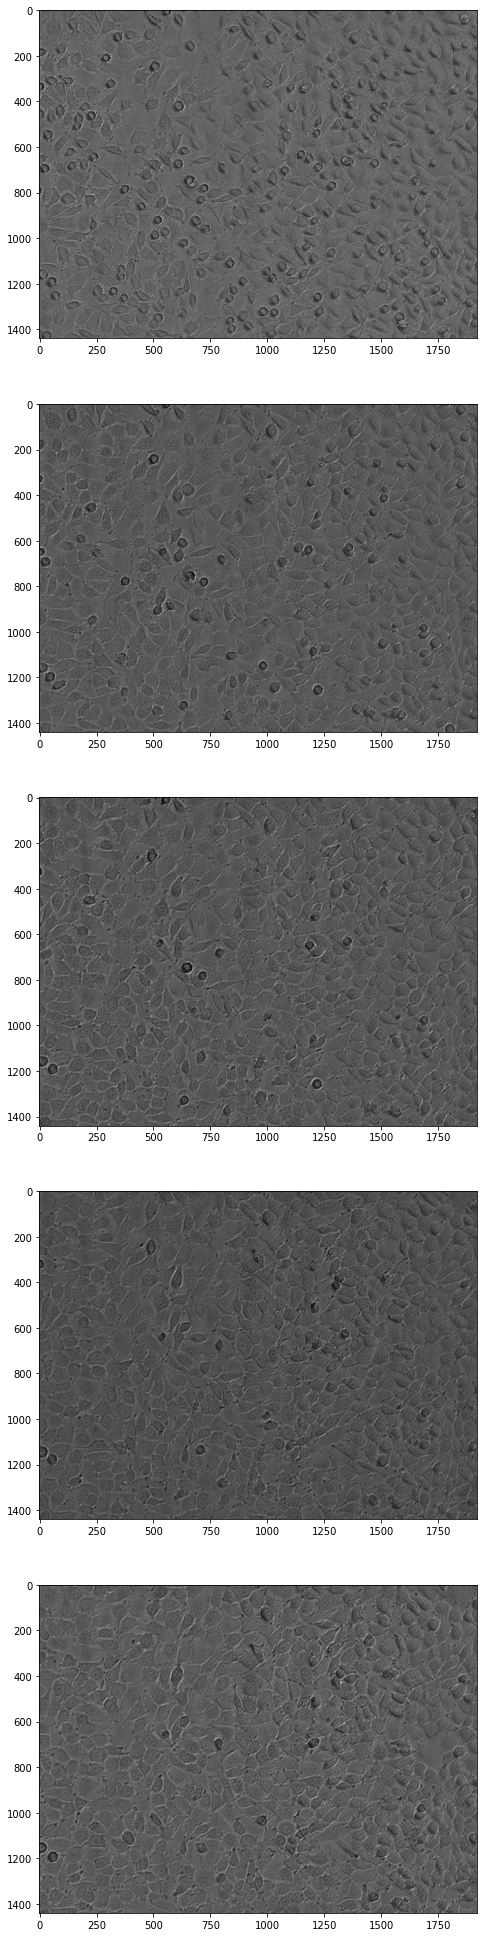

In [26]:
nplots = 5
fig, ax = plt.subplots(nplots, figsize=(7 * nplots, 7 * nplots))

ax[0].imshow(arr_bgs[0], "gray")
ax[1].imshow(arr_bgs[1], "gray")
ax[2].imshow(arr_bgs[2], "gray")
ax[3].imshow(arr_bgs[3], "gray")
ax[4].imshow(arr_bgs[4], "gray")